In [3]:
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood

import numpy as np
import os
import uproot

%matplotlib inline
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import the root files into a DataFrame


In [5]:
# Define the base directory and the range of subdirectories
base_dir = "/eos/user/d/dvoss/Run3ModelGen/6249447/"
subdir_range = range(0, 20)  # Adjust range to include subdirectories to 20

# List to store data from all files
all_data = []

for subdir in subdir_range:
    file_path = os.path.join(base_dir, str(subdir), f"ntuple.6249447.{subdir}.root")
    
    try:
        # Open the ROOT file
        file = uproot.open(file_path)
        
        # Assuming the data you want is in a specific tree
        tree_name = "susy"  # Replace with the actual tree name
        tree = file[tree_name]
        
        # Convert tree to pandas DataFrame or any other format you prefer
        df = tree.arrays(library="pd")
        
        # Append the DataFrame to the list
        all_data.append(df)
        
    except Exception as e:
        print(f"Failed to open or process {file_path}: {e}")

# Concatenate all DataFrames into a single DataFrame if using pandas
import pandas as pd
final_df = pd.concat(all_data, ignore_index=True)

Split into training and validation data:

In [19]:
M_1 = final_df['IN_M_1']
M_2 = final_df['IN_M_2']
Omega = final_df['MO_Omega']

# Filter Omega, M_1, and M_2 up to max 1.0 and limit to only 100 points
mask = (Omega > 0) & (Omega < 1.0)

# Apply the mask to filter M_1, M_2, and Omega
M_1_filtered = M_1[mask]
M_2_filtered = M_2[mask]
Omega_filtered = Omega[mask]

# Limit to only 100 points
M_1_limited = M_1_filtered.iloc[:1000]
M_2_limited = M_2_filtered.iloc[:1000]
Omega_limited = Omega_filtered.iloc[:1000]

# Convert to train
x_train = torch.stack([torch.tensor(M_1_limited.values[:700], dtype=torch.float32), torch.tensor(M_2_limited.values[:700], dtype=torch.float32)], dim=1)
y_train = torch.tensor(Omega_limited.values[:700], dtype=torch.float32)


# Convert to valid
x_valid = torch.stack([torch.tensor(M_1_limited.values[700:], dtype=torch.float32), torch.tensor(M_2_limited.values[700:], dtype=torch.float32)], dim=1)
y_valid = torch.tensor(Omega_limited.values[700:], dtype=torch.float32)

In [20]:
from multitaskGP2D import MultitaskGP2D

likelihood = GaussianLikelihood()
multitask_gp = MultitaskGP2D(x_train, y_train, x_valid, y_valid, likelihood, 2)

best_multitask_gp, losses, losses_valid = multitask_gp.do_train_loop(iters=200)

weights: torch.Size([2, 1])
X: torch.Size([700, 2])
X: tensor([[ -643.8203,   215.2559],
        [ 1500.5386,  1472.1405],
        [ 1322.3553,   708.9592],
        ...,
        [ 1705.6624,   758.4684],
        [ 1497.3445,   181.4679],
        [-1150.0846,   783.2943]])
weights: Parameter containing:
tensor([[0.1000],
        [0.1000]], requires_grad=True)
Iteration 0: x_train shape: torch.Size([700, 2]), y_train shape: torch.Size([700])
Output mean shape: torch.Size([700])
weights: torch.Size([2, 1])
X: torch.Size([700, 2])
X: tensor([[ -643.8203,   215.2559],
        [ 1500.5386,  1472.1405],
        [ 1322.3553,   708.9592],
        ...,
        [ 1705.6624,   758.4684],
        [ 1497.3445,   181.4679],
        [-1150.0846,   783.2943]])
weights: Parameter containing:
tensor([[0.0900],
        [0.0900]], requires_grad=True)
weights: torch.Size([2, 1])
X: torch.Size([1000, 2])
X: tensor([[-643.8203,  215.2559],
        [1500.5386, 1472.1405],
        [1322.3553,  708.9592],
      

Plot losses

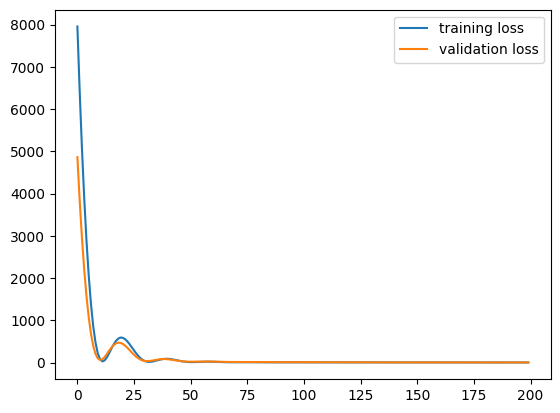

In [21]:
plt.plot(losses, label='training loss')
plt.plot(losses_valid, label='validation loss')
plt.legend()

Best parameters:

In [22]:
best_multitask_gp.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.1731])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.weights',
              tensor([[-2.0541e-05],
                      [-7.8394e-04]])),
             ('mean_module.bias', tensor([0.8638])),
             ('covar_module.raw_lengthscale', tensor([[-5.2958]])),
             ('covar_module.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('task_covar_module.covar_factor', tensor([[-0.3077]])),
             ('task_covar_module.raw_var', tensor([0.7238])),
             ('task_covar_module.IndexKernelPrior.a', tensor([0.])),
             ('task_covar_module.IndexKernelPrior.b', tensor([1.])),
             ('task_cova

In [23]:
params = best_multitask_gp.named_parameters()

for name, param in params:
    print(f"Name: {name}, Value: {param.data}")

Name: likelihood.noise_covar.raw_noise, Value: tensor([0.1731])
Name: mean_module.weights, Value: tensor([[-2.0541e-05],
        [-7.8394e-04]])
Name: mean_module.bias, Value: tensor([0.8638])
Name: covar_module.raw_lengthscale, Value: tensor([[-5.2958]])
Name: task_covar_module.covar_factor, Value: tensor([[-0.3077]])
Name: task_covar_module.raw_var, Value: tensor([0.7238])


Evaluate on test data & get entropy

In [31]:
x_test = torch.stack([torch.tensor(M_1_filtered.values[1000:10000], dtype=torch.float32), torch.tensor(M_2_filtered.values[1000:10000], dtype=torch.float32)], dim=1)

In [33]:
from entropy import entropy_local 

def evaluate(multitask_gp, likelihood, x_test):
    """Evaluate GP on test sample and calculate corresponding entropies."""

    multitask_gp.eval()
    likelihood.eval()

    with torch.no_grad():
        # Get prediction:
        observed_pred = likelihood(multitask_gp(x_test))

        # Get upper and lower confidence bounds
        mean = observed_pred.mean.detach().reshape(-1, 1)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        dtype = torch.float32
        var = observed_pred.variance.detach().reshape(-1, 1)
        thr = torch.Tensor([0.]) # Threshold in CDF calculation. Needs to be more sophisticated if params are scaled.

        entropy = entropy_local(mean, var, thr, device, dtype)
        
    return observed_pred, entropy

observed_pred, entropy = evaluate(multitask_gp, likelihood, x_test)

weights: torch.Size([2, 1])
X: torch.Size([9700, 2])
X: tensor([[ -643.8203,   215.2559],
        [ 1500.5386,  1472.1405],
        [ 1322.3553,   708.9592],
        ...,
        [-1592.1980,   513.7538],
        [ 1505.7780,   219.7428],
        [-1797.1146,   679.7434]])
weights: Parameter containing:
tensor([[-2.0541e-05],
        [-7.8394e-04]], requires_grad=True)


Plot the True Function next to the GP:

In [34]:
mean = observed_pred.mean.numpy()

print(x_test.shape)
print(x_train.shape)
print(torch.tensor(mean).shape)
print(y_train.shape)
print(torch.tensor(mean))
print(y_train)

torch.Size([9000, 2])
torch.Size([700, 2])
torch.Size([9000])
torch.Size([700])
tensor([-0.5404,  0.4057, -0.0252,  ...,  0.4937,  0.6606,  0.3678])
tensor([1.3800e-03, 4.4200e-01, 1.4100e-02, 1.1600e-02, 1.1300e-02, 1.6700e-02,
        6.2900e-02, 1.0700e-02, 6.5300e-03, 2.5600e-03, 9.2900e-04, 2.7100e-02,
        6.4000e-02, 1.1000e-01, 5.1000e-03, 1.9200e-02, 2.0300e-03, 5.7000e-02,
        3.1400e-03, 7.0000e-02, 6.1400e-04, 1.5600e-01, 4.5600e-03, 2.0800e-03,
        1.6200e-02, 1.6400e-02, 9.7600e-04, 1.5100e-02, 1.9300e-05, 1.0400e-02,
        4.3800e-03, 2.6600e-02, 7.7300e-04, 2.7500e-04, 5.1100e-01, 3.5400e-02,
        9.1200e-01, 1.6900e-02, 6.5600e-02, 3.5300e-02, 2.7000e-02, 1.4700e-02,
        2.9900e-05, 6.0800e-04, 2.3600e-02, 3.0900e-02, 3.0900e-02, 2.0900e-02,
        3.2000e-03, 3.8500e-04, 9.8100e-03, 3.9000e-03, 4.9300e-02, 7.8000e-04,
        2.2100e-02, 3.6500e-02, 5.7500e-02, 4.5300e-02, 3.2500e-03, 5.0500e-03,
        2.7100e-02, 4.2900e-03, 3.4500e-02, 8.2900e

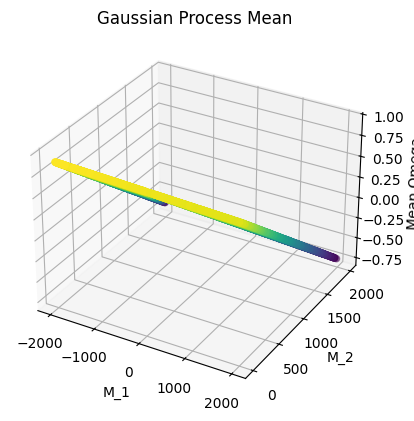

In [35]:
# Sample data
x = x_test[:,0]
y = x_test[:,1]
z = torch.tensor(mean)

# Create a new figure and 3D subplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot data points
sc = ax.scatter(x, y, z, c=z, cmap='viridis')

# Set labels and title
ax.set_xlabel('M_1')
ax.set_ylabel('M_2')
ax.set_zlabel('Mean Omega')
ax.set_title('Gaussian Process Mean')

# Display the plot
plt.show()

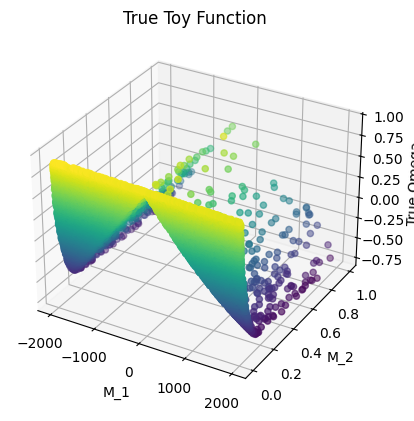

In [37]:
y = torch.tensor(Omega_filtered.values[1000:10000], dtype=torch.float32)

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis')

# Set plot labels and title
ax.set_xlabel('M_1')
ax.set_ylabel('M_2')
ax.set_zlabel('True Omega')
ax.set_title('True Toy Function')

# Show the plot
plt.show()

In [38]:
mean = observed_pred.mean.numpy()
lower, upper = observed_pred.confidence_region()

# Find the top 10 highest entropy values and their indices
topk_values, topk_indices = torch.topk(entropy, 10)
tenX = x_test[topk_indices]

maxE = torch.max(entropy)
maxIndex = torch.argmax(entropy)
maxX = x_test[maxIndex]

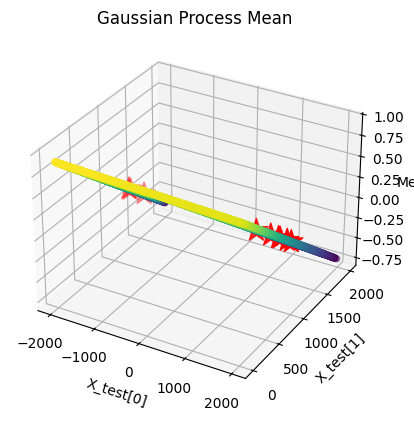

In [39]:
# Sample data
x = x_test[:,0]
y = x_test[:,1]
z = mean

# Extract the top 10 points with the highest entropy
top_10_points = x_test[topk_indices]
top_10_means = torch.tensor(mean[topk_indices])

# Create a new figure and 3D subplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot data points
ax.scatter(x, y, z, c=z, cmap='viridis' )

# Plot the top 10 points with highest entropy as stars
ax.scatter(top_10_points[:, 0].numpy(), top_10_points[:, 1].numpy(), top_10_means.numpy(), 
           color='r', marker='*', s=300, label='Top 10 High Entropy Points')

# Set labels and title
ax.set_xlabel('X_test[0]')
ax.set_ylabel('X_test[1]')
ax.set_zlabel('Mean')
ax.set_title('Gaussian Process Mean')

# Display the plot
plt.show()

In [40]:
def plotGP(new_x = None):
    """Plot GP inclusive entropy"""

    mean = observed_pred.mean.numpy()
    lower, upper = observed_pred.confidence_region()

    # # Initialize plot
    # _, ax = plt.subplots(1, 1, figsize=(10, 6))

    # # Plot training data as black stars
    # ax.plot(x_train.numpy(), y_train.numpy(), 'k*', label='Training Data')
    # # Plot predictive means as blue line
    # ax.plot(x_test.numpy(), mean, 'b', label='Learnt Function')
    # # Shade between the lower and upper confidence bounds
    # ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence')
    # # ax.set_ylim([-3, 3])
    # ax.plot(x_test, y_test, 'r', label='Truth')

    # # Add new points to be evaluated:
    # if new_x is not None:
    #     dolabel = True
    #     for xval in new_x:
    #         ax.axvline(x=xval, color='r', linestyle='--', label='new points') if dolabel else ax.axvline(x=xval, color='r', linestyle='--')
    #         dolabel = False

    # ax2 = ax.twinx()
    # ax2.set_ylabel("entropy")
    # ax2.plot(x_test, entropy, 'g', label='Entropy')

    maxE = torch.max(entropy)
    maxIndex = torch.argmax(entropy)
    maxX = x_test[maxIndex]
    # ax2.plot(maxX, maxE, 'go', label='Max. E')

    # add common legend:
    # lines, labels = ax.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    # ax2.legend(lines + lines2, labels + labels2)

plotGP()

Find new target for training based on entropy (skipping batch acquisiton for now)

In [41]:
maxE = torch.max(entropy)
maxIndex = torch.argmax(entropy)
maxX = x_test[maxIndex]
print(torch.tensor([maxX]))

print(f"Maximum entropy E={torch.max(entropy)} at x={maxX}")

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
print(x_train.shape)
print(maxX.shape)
x_train = torch.cat((x_train, maxX), dim=0)
x_train = torch.cat((x_train, torch.tensor([maxX])), dim=0)
y_train = torch.cat((y_train, objective(torch.tensor([maxX]))), dim=0) # Here i could use the mean instead of the evaluated function

x_train, y_train

torch.Size([10, 2])
torch.Size([2])


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

Re-train with added sample:

In [ ]:
multitask_gp = MultitaskGP(x_train, y_train, x_valid, y_valid, likelihood)
best_multitask_gp, losses, losses_valid = multitask_gp.do_train_loop(iters=2000)

Iter 1 / 2000 - Loss (Train): 1.378 - Loss (Val): 1.318
Iter 101 / 2000 - Loss (Train): 0.970 - Loss (Val): -0.370
Iter 201 / 2000 - Loss (Train): 0.164 - Loss (Val): -2.402
Iter 301 / 2000 - Loss (Train): 0.159 - Loss (Val): -2.391
Iter 401 / 2000 - Loss (Train): 0.157 - Loss (Val): -2.388
Iter 501 / 2000 - Loss (Train): 0.156 - Loss (Val): -2.390
Iter 601 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.387
Iter 701 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.390
Iter 801 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.391
Iter 901 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.392
Iter 1001 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.390
Iter 1101 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.391
Iter 1201 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.390
Iter 1301 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.389
Iter 1401 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.392
Iter 1501 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.393
Iter 1601 / 2000 - Loss (Train): 0.155 - Loss (Val): 

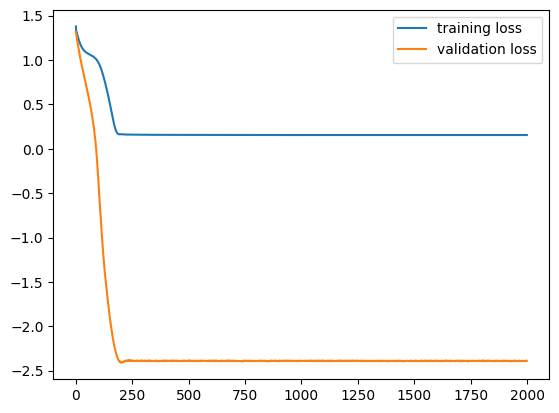

In [ ]:
plt.plot(losses, label='training loss')
plt.plot(losses_valid, label='validation loss')
plt.legend()

Evaluate again & plot the updated GP:

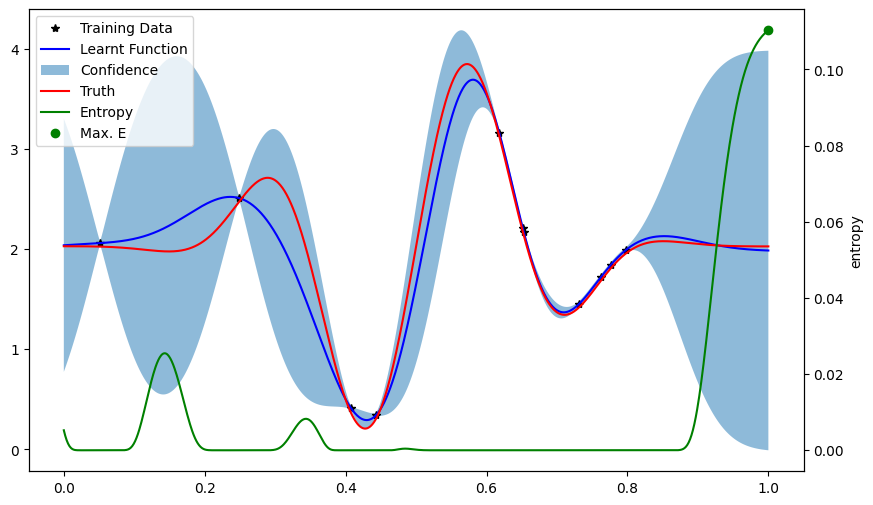

In [ ]:
observed_pred, entropy = evaluate(multitask_gp, likelihood, x_test)
plotGP()

Closing the loop with batch acquisition:

In [ ]:
def best_not_yet_chosen(score, previous_indices):

  candidates = torch.sort(score, descending = True)[1]

  for next_index in candidates:
    if int(next_index) not in previous_indices:
      return next_index

def iterative_batch_selector(score_function, 
                             choice_function = best_not_yet_chosen,
                             gp_mean = None, 
                             gp_covar= None, 
                             N = None):

  #make it a decorator
  if gp_mean is None:
    def greedy_batch_sel(gp_mean, gp_covar, N):
      return iterative_batch_selector(score_function, choice_function, gp_mean, gp_covar, N)
    return greedy_batch_sel
  


  #actual_function starts here

  #First point greedy
  score = score_function(gp_mean[:,None], torch.diag(gp_covar)[:,None,None])
  first_index = torch.argmax(score)
  indices = [int(first_index)]

  #Iterate for all points
  num_pts = len(gp_mean)

  for i in range(N-1):

    #Create the batched cov matrices
    center_cov = torch.stack([gp_covar[indices,][:,indices]]*num_pts)
    side_cov = gp_covar[:,None,indices]
    bottom_cov =  gp_covar[:,indices, None]
    end_cov = torch.diag(gp_covar)[:,None,None]

    cov_batch = torch.cat([
                  torch.cat([center_cov, side_cov],axis = 1),
                  torch.cat([bottom_cov, end_cov ],axis = 1),
                  ], axis = 2)
    
    #Create the batched mean vectors
    center_mean = torch.stack([gp_mean[indices,]]*num_pts)
    new_mean = gp_mean[:,None]


    mean_batch = torch.cat([center_mean,new_mean],axis=1)

    score = score_function(mean_batch,cov_batch)

    next_index = choice_function(score, indices)

    indices.append(int(next_index))

  return indices

In [ ]:
def approximate_batch_entropy(mean, cov):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  mean = mean
  n = mean.shape[-1]
  d = torch.diag_embed(1./mean).to(device) #like torch.diag but batches well
  x = d@cov@d.to(device)
  I = torch.eye(n)[None,:,:].to(device)
  return (torch.logdet(x+I)-torch.logdet(x+2*I)+n*np.log(2))/np.log(2)

def smoothed_batch_entropy(blur):
  return lambda mean,cov: approximate_batch_entropy(mean+blur*torch.sign(mean),cov)

def gibbs_sample(beta):

  def sampler(score,indices = None):
    probs = torch.exp(beta*(score-torch.max(score)))
    probs/=torch.sum(probs)
    cums = torch.cumsum(probs,dim=0)
    rand = torch.rand(size = (1,))[0]
    return torch.sum(cums<rand)

  return sampler

Use selector to make choice which points to sample:

In [ ]:
selector = iterative_batch_selector(score_function = smoothed_batch_entropy(blur = 0.15),
                                    choice_function = gibbs_sample(beta = 50))  #100 BETTER

with torch.no_grad(), gpytorch.settings.fast_pred_var():

  # take observed_pred from test points
  mean = observed_pred.mean.detach()
  covar = observed_pred.covariance_matrix.detach()
  thr = torch.Tensor([0.]) # threshold in CDF calculation. Needs to be more sophisticated if params are scaled.

  points = set(selector(N=4, gp_mean=mean-thr, gp_covar=covar) )
  new_x = x_test[list(points)]
  
print("points:", points)
print("Corresponding xs:", new_x)

points: {968, 223, 127, 999}
Corresponding xs: tensor([0.9690, 0.2232, 0.1271, 1.0000])


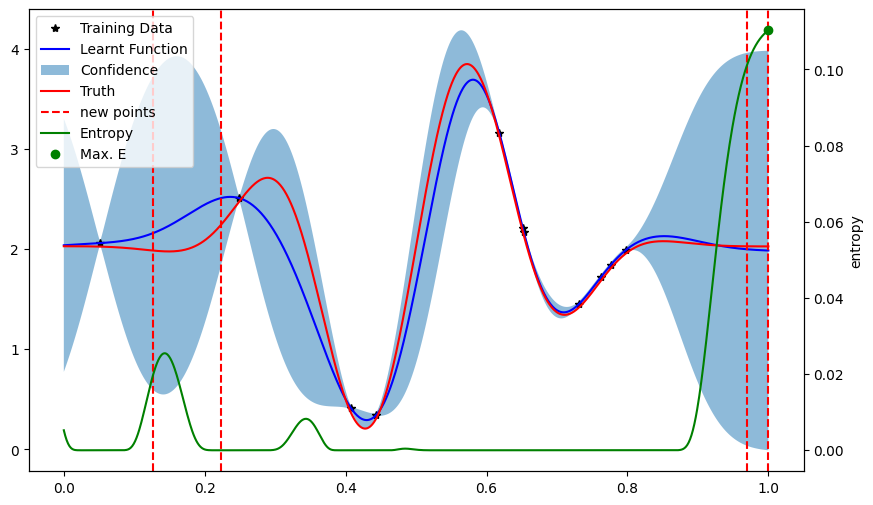

In [ ]:
plotGP(new_x=new_x)